In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [15]:
df = pd.read_csv('PlasticSales.csv', parse_dates = ['Month'], index_col = ['Month'])
df.head(10)

,Sales
Month,
2049-01-01,742
2049-02-01,697
2049-03-01,776
2049-04-01,898
2049-05-01,1030
2049-06-01,1107
2049-07-01,1165
2049-08-01,1216
2049-09-01,1208


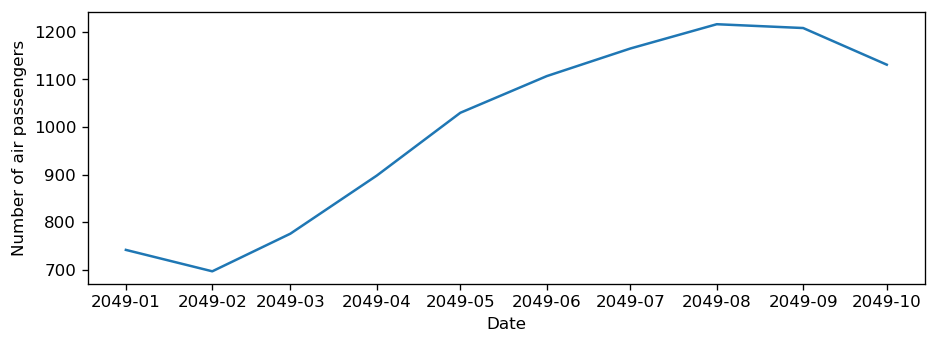

In [16]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df.head(10))

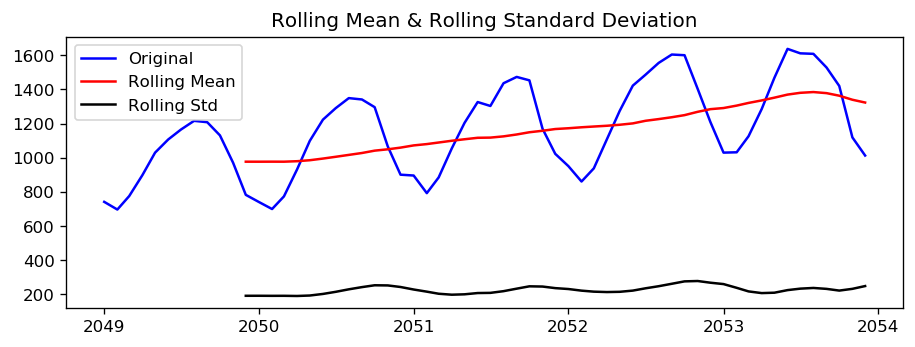

In [17]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [19]:
result = adfuller(df['Sales'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.7425639844129008
p-value: 0.8354143931554416
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153


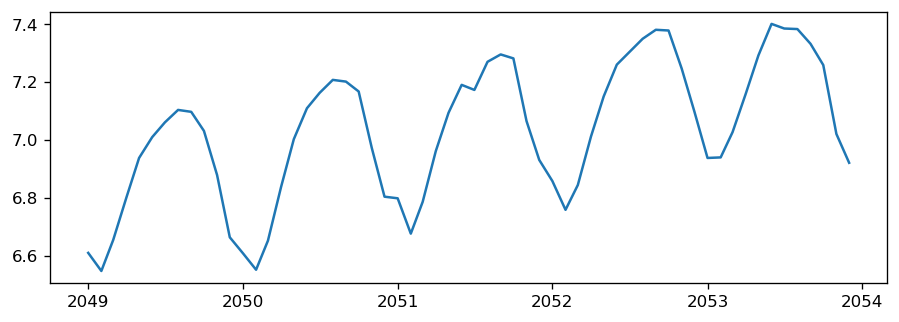

In [21]:
df_log = np.log(df)
plt.plot(df_log)
plt.show()

In [25]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Sales'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

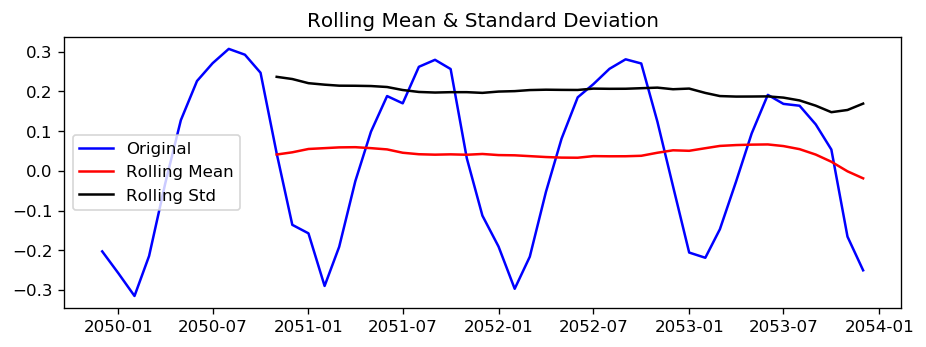

ADF Statistic: -5.528528992970021
p-value: 1.8095434424509528e-06
Critical Values:
	1%: -3.5925042342183704
	5%: -2.931549768951162
	10%: -2.60406594375338


In [26]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean)

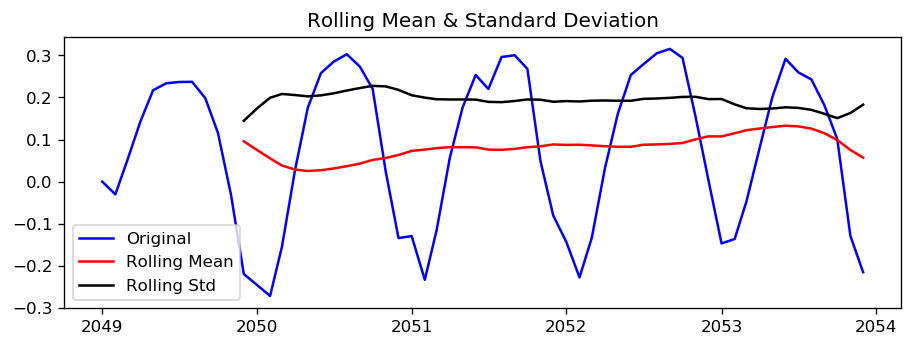

ADF Statistic: -5.587402129701624
p-value: 1.353121637848083e-06
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


In [27]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

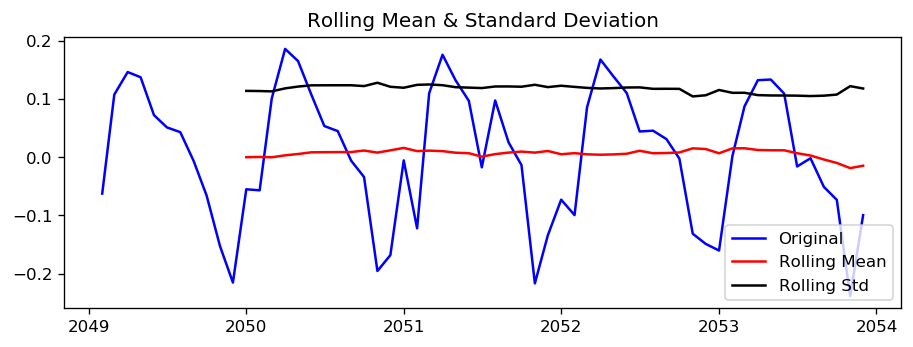

ADF Statistic: -0.8096644464205993
p-value: 0.8162667125730272
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064


In [28]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


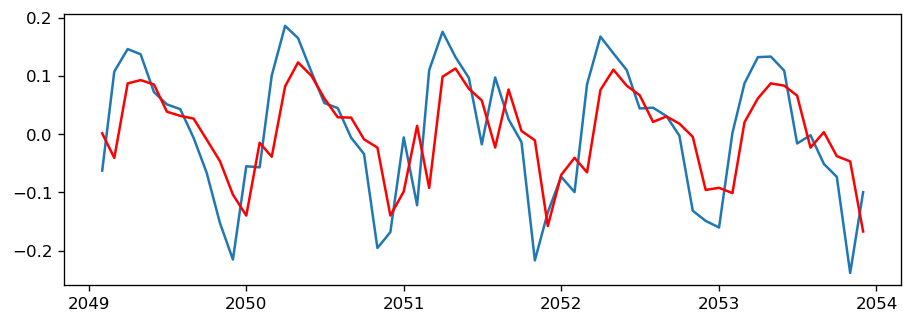

In [34]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(1,1,1))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

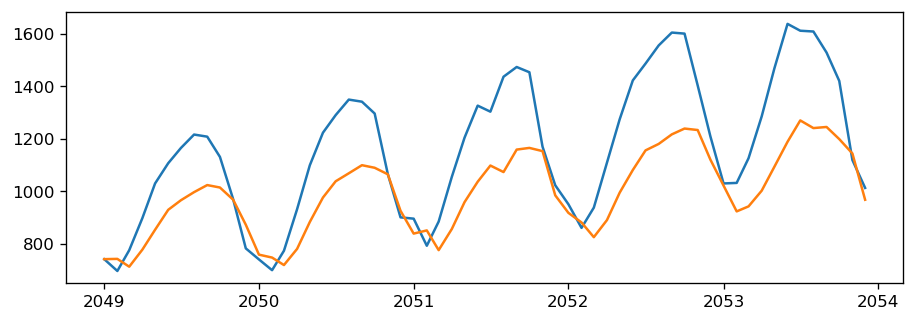

In [36]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Sales'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

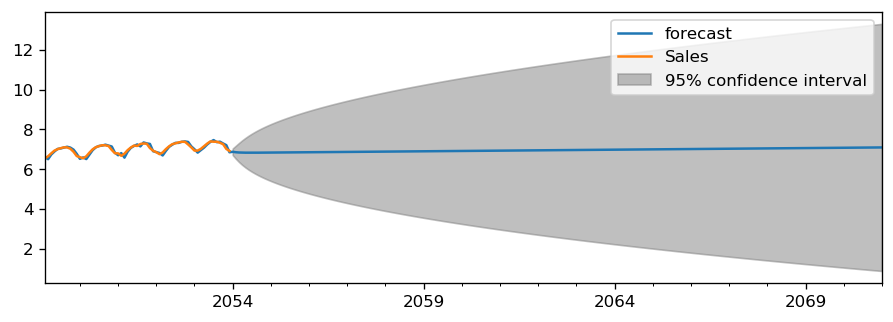

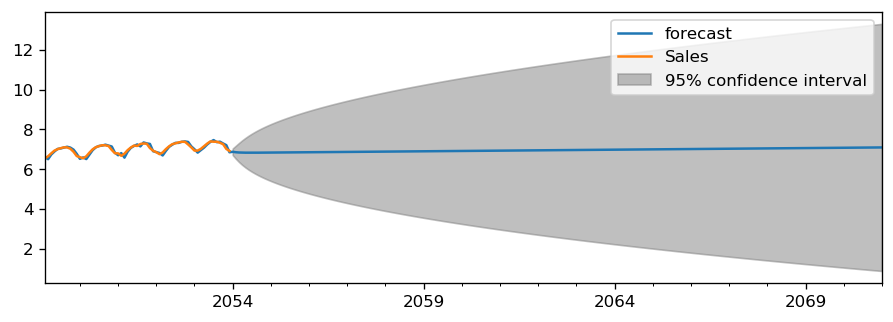

In [37]:
results.plot_predict(1,264)